## Sparse approximations

### Stochastic Variational Inference for scalability with SVGP

In [1]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import *
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 
tf.random.set_seed(42)
np.random.seed(42)

2023-04-04 14:04:57.574861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


In [7]:
#X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('boston', 0)
#D = X_train.shape[1]
X, Y = create_dataset('yacht', 42, False)

In [8]:
from sklearn.model_selection import KFold
def run_adam(model, train_dataset, minibatch_size, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

def kfold_cv_model(model=None, prior=None, kernel=None, k_folds=None, model_params=None, iprint=False):
    results = {'train_rmse': [], 
            'test_rmse': [], 
            'train_mnll': [], 
            'test_mnll': [], 
            'avg_train_rmse': 0.,
            'avg_test_rmse': 0.,
            'avg_train_mnll': 0.,
            'avg_test_mnll': 0.,}
    D = X.shape[1]
    for i, (train_index, test_index) in enumerate(k_folds.split(X)):
        # Define X_train, Y_train, X_test, Y_test for fold i
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        Y_train = Y[train_index]
        Y_test = Y[test_index]
        Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_std

        # Define the kernel: RBF(standard) or Lambda RBF
        if kernel == 'RBF':
            kernel = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
        elif kernel == 'LRBF':
            lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
            Lambda_L = get_lower_triangular_from_diag(lengthscales)
            Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
            kernel = LambdaRBF(Lambda_L_array, 1.0)

        # Initialize the model: GPR or SVGP
        if model == 'GPR':
            model = gpflow.models.GPR(
                (X_train, Y_train),
                kernel=kernel,
            )
            # Optimize hyperparameters
            opt = gpflow.optimizers.Scipy()
            opt.minimize(model.training_loss, model.trainable_variables)
            
        elif model == 'SVGP':
            num_inducing = model_params['num_inducing']
            lik = model_params['likelihood']
            Z = X_train[:num_inducing, :].copy()
            maxiter = model_params['max_iter']
            minibatch_size = model_params['minibatch_size']
            model = gpflow.models.SVGP(kernel, lik, Z, num_data=num_inducing)
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(X_train.shape[0])
            logf = run_adam(model, train_dataset, minibatch_size, maxiter)

        # Measure performances
        train_rmse_stan, test_rmse_stan = measure_rmse(model, X_train, Y_train, X_test, Y_test)
        train_mnll, test_mnll = measure_mnll(model, X_train, Y_train, Y_train_std, X_test, Y_test)
        results['train_rmse'].append(train_rmse_stan)
        results['test_rmse'].append(test_rmse_stan)
        results['train_mnll'].append(train_mnll)
        results['test_mnll'].append(test_mnll)


    results['avg_train_rmse'] = np.mean(results['train_rmse'])
    results['avg_test_rmse'] = np.mean(results['test_rmse'])
    results['avg_train_mnll'] = np.mean(results['train_mnll'])
    results['avg_test_mnll'] = np.mean(results['test_mnll'])
    if iprint:
        print('-- Model: %s; Kernel: %s; --'%(model, kernel))
        print('Average test RMSE: %5.3f\nAverage test MNLL: %5.3f\n'%(results['avg_test_rmse'], results['avg_test_mnll']))
    return results
kfolds = KFold(n_splits = 8)
model_params = {'num_inducing': 100, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 1000}
results_RBF = kfold_cv_model(model='SVGP', kernel='RBF', k_folds=kfolds, model_params=model_params, iprint=True)
results_LRBF = kfold_cv_model(model='SVGP', kernel='LRBF', k_folds=kfolds, model_params=model_params, iprint=True)

-- Model: <gpflow.models.svgp.SVGP object at 0x7fc6172c5130>; Kernel: <gpflow.kernels.stationaries.SquaredExponential object at 0x7fc614a05280>; --
Average test RMSE: 0.052
Average test MNLL: 1.675

-- Model: <gpflow.models.svgp.SVGP object at 0x7fc6149a3070>; Kernel: Variance: <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=2.649600652105752>
Lambda: [[ 2.17262699e-04 -4.67237123e-04  5.39583268e-04 -7.93633776e-04
  -6.92401091e-04  1.47745076e-02]
 [-4.67237123e-04  2.17291222e-03 -2.35094637e-05  1.46967417e-03
   6.42538818e-04 -3.83571480e-02]
 [ 5.39583268e-04 -2.35094637e-05  2.56974160e-03 -2.33811077e-03
  -2.65514765e-03  3.05125271e-02]
 [-7.93633776e-04  1.46967417e-03 -2.33811077e-03  3.09942394e-03
   2.82347908e-03 -5.28997752e-02]
 [-6.92401091e-04  6.42538818e-04 -2.65514765e-03  2.82347908e-03
   2.92746432e-03 -4.25048504e-02]
 [ 1.47745076e-02 -3.83571480e-02  3.05125271e-02 -5.28997752e-02
  -4.25048504e-02  1.04241175e+00]]; --
Ave

In [2]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('boston', 0)
D = X_train.shape[1]

In [3]:
M = 100  # Number of inducing locations
N = X_train.shape[0] # Number of training points
data = (X_train, Y_train)

lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
LRBF = LambdaRBF(Lambda_L_array, 1.0)
Z = X_train[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset

model_SVGP = gpflow.models.SVGP(LRBF, gpflow.likelihoods.Gaussian(), Z, num_data=N)

In [4]:
# This gives a variational bound (the evidence lower bound or ELBO) on the log marginal likelihood of the model.
elbo = tf.function(model_SVGP.elbo)
tensor_data = tuple(map(tf.convert_to_tensor, data)) # Tuple of tensors
ground_truth = elbo(tensor_data).numpy()
print('ELBO ground truth: %3.2f'%(ground_truth)) 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
ELBO ground truth: -775.25


In [5]:
minibatch_size = 100
# from_tensor_slices creates a Dataset with a seprate elment for each row of the input tensor
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(N)

In [8]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [8]:
gpflow.utilities.print_summary(model_SVGP, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.Lambda_L,Parameter,Identity,,True,"(91,)",float64,"[0.27735, 0., 0...."
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(100, 13)",float64,"[[-0.37885, -0.48772, -0.72032..."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


In [ ]:
opt = gpflow.optimizers.Scipy()
opt.minimize(
    model_SVGP.training_loss_closure((X_train, Y_train)),
    variables=model_SVGP.trainable_variables,
    method="l-bfgs-b",
    options={"iprint": 0, "maxiter": 2000},
)

In [11]:
maxiter = 10000
logf = run_adam(model_SVGP, maxiter)

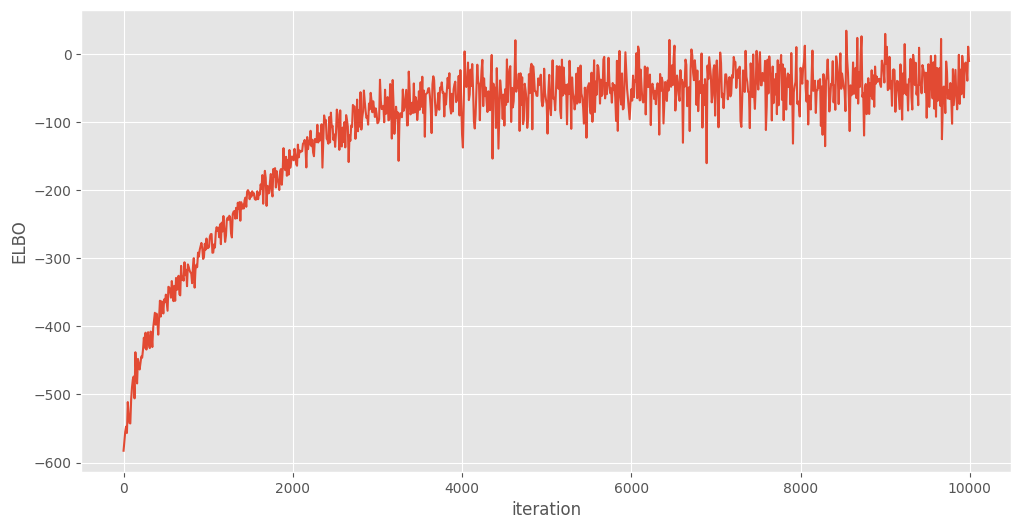

In [12]:
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [20]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_SVGP, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.209
Test RMSE (Standardised): 0.458
